# Enhancing Single-Image Super-Resolution

Muneerah AlDhafian (446200418),
Maha AlHazzani (446201187),
and Reem AlShehri (446200905)

CSC 564: ML

Department of computer science

King Saud University


# 1. Preparations
Before start, make sure that you choose
* Runtime Type = Python 3
* Hardware Accelerator = GPU

# 2. Project Roadmap
1. Import Libraries
2. Dataset
3. Baseline Models
  - GAN


In [ ]:
!pip install torch torchvision tqdm opencv-python
!pip install scikit-image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 125.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 78.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import save_image
from tqdm import tqdm
import torchvision.models as models
import torch.nn as nn
import torch.nn as nn
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import time
from tqdm.notebook import tqdm
from PIL import Image, ImageFilter
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision.models import vgg19
from skimage.metrics import peak_signal_noise_ratio as calculate_psnr
from skimage.metrics import structural_similarity as calculate_ssim # For SSIM Loss if needed later
from tqdm import tqdm


### 1.1 Download and Extract DIV2K Dataset

The following cells download the necessary DIV2K dataset components (Train HR/LR, Valid HR/LR) and extract them into the `/content/data` directory.

In [ ]:
# Create data directory
!mkdir -p /content/data
%cd /content/data

# Download Train Set (HR and LR)
print("Downloading DIV2K Training Set...")
!wget -c http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
!wget -c http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X4.zip

# Download Validation Set (HR and LR)  - This will be our Test Set
print("Downloading DIV2K Validation Set (used as Test Set)...")
!wget -c http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip
!wget -c http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X4.zip

# Extract downloaded files
print("Extracting files...")
!unzip -o -q DIV2K_train_HR.zip
!unzip -o -q DIV2K_train_LR_bicubic_X4.zip -d DIV2K_train_LR_bicubic # Extract LR into its own subdir
!unzip -o -q DIV2K_valid_HR.zip
!unzip -o -q DIV2K_valid_LR_bicubic_X4.zip -d DIV2K_valid_LR_bicubic # Extract LR into its own subdir

print("Dataset download and extraction complete.")
%cd /content # Corrected: Change back to root directory (comment removed)

/content/data
--2025-05-04 22:18:41--  http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip [following]
--2025-05-04 22:18:41--  https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

--2025-05-04 22:18:42--  http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X4.zip
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|1

### 1.2 Dataset Paths and Parameters

Define paths to the downloaded DIV2K dataset components. We will use the DIV2K *training* set for training and validation, and the DIV2K *validation* set as our final test set.

In [ ]:
# Define paths (assuming data is downloaded in /content/data)
base_data_path = "/content/data"

# Check if the base path exists after download/extraction
if not os.path.exists(base_data_path) or not os.path.exists(os.path.join(base_data_path, "DIV2K_train_HR")):
    print(f"Warning: Dataset path {base_data_path} or its contents not found. Please ensure the download/extraction cell ran successfully.")
else:
    print(f"Dataset base path found: {base_data_path}")

train_hr_dir = os.path.join(base_data_path, "DIV2K_train_HR")
# Corrected path for LR train images based on unzip structure
train_lr_dir = os.path.join(base_data_path, "DIV2K_train_LR_bicubic", "DIV2K_train_LR_bicubic", "X4")

# Use the original DIV2K validation set as our test set
test_hr_dir = os.path.join(base_data_path, "DIV2K_valid_HR")
# Corrected path for LR test images based on unzip structure
test_lr_dir = os.path.join(base_data_path, "DIV2K_valid_LR_bicubic", "DIV2K_valid_LR_bicubic", "X4")

# Parameters
scale_factor = 4
hr_patch_size = 96 # Size of HR patches to crop for training
lr_patch_size = hr_patch_size // scale_factor # Corresponding LR patch size
batch_size = 8 # Adjust based on GPU memory
validation_split = 0.1 # Use 10% of training data for validation

Dataset base path found: /content/data


### 1.3 Dataset Class with Random Cropping

This dataset class loads HR/LR pairs and applies random cropping and augmentations during training.

In [ ]:

class DIV2KCroppedDataset(Dataset):
    def __init__(self, hr_dir, lr_dir, hr_patch_size, scale_factor, split="train", transform=None):
        self.hr_dir = hr_dir
        self.lr_dir = lr_dir
        self.hr_patch_size = hr_patch_size
        self.lr_patch_size = hr_patch_size // scale_factor
        self.scale_factor = scale_factor
        self.split = split
        self.transform = transform
        self.hr_image_files = sorted(glob.glob(os.path.join(hr_dir, "*.png")))
        # LR files are expected inside the X4 subdirectory
        self.lr_image_files = sorted(glob.glob(os.path.join(lr_dir, "*.png")))

        if not self.hr_image_files:
            raise FileNotFoundError(f"No HR images found in {hr_dir}")
        if not self.lr_image_files:
             raise FileNotFoundError(f"No LR images found in {lr_dir}")

        # Verify counts (optional but good practice)
        print(f"Found {len(self.hr_image_files)} HR images in {hr_dir}")
        print(f"Found {len(self.lr_image_files)} LR images in {lr_dir}")

    def __len__(self):
        return len(self.hr_image_files)

    def __getitem__(self, idx):
        hr_img_path = self.hr_image_files[idx]
        # Construct LR path based on HR filename (e.g., 0001.png -> 0001x4.png)
        hr_basename = os.path.basename(hr_img_path)
        lr_basename = hr_basename.replace(".png", f"x{self.scale_factor}.png")
        lr_img_path = os.path.join(self.lr_dir, lr_basename)

        try:
            hr_image = Image.open(hr_img_path).convert("RGB")
            lr_image = Image.open(lr_img_path).convert("RGB")
        except FileNotFoundError:
            print(f"Error loading image pair: HR={hr_img_path}, Expected LR={lr_img_path}")
            # Handle error, e.g., skip this sample or return dummy data
            # For simplicity, let's try loading the next image
            return self.__getitem__((idx + 1) % len(self))

        if self.split == "train":
            # Get random crop parameters based on LR image size
            lr_w, lr_h = lr_image.size
            if lr_w < self.lr_patch_size or lr_h < self.lr_patch_size:
                # If LR image is too small, resize it up slightly bigger than patch size
                target_size = max(self.lr_patch_size, lr_w, lr_h)
                lr_image = TF.resize(lr_image, target_size, interpolation=Image.BICUBIC)
                hr_image = TF.resize(hr_image, target_size * self.scale_factor, interpolation=Image.BICUBIC)

            i, j, h, w = transforms.RandomCrop.get_params(
                lr_image, output_size=(self.lr_patch_size, self.lr_patch_size)
            )
            lr_patch = TF.crop(lr_image, i, j, h, w)
            hr_patch = TF.crop(hr_image, i * self.scale_factor, j * self.scale_factor, h * self.scale_factor, w * self.scale_factor)

            # Apply random horizontal flip
            if random.random() > 0.5:
                lr_patch = TF.hflip(lr_patch)
                hr_patch = TF.hflip(hr_patch)

            # Apply random vertical flip
            if random.random() > 0.5:
                lr_patch = TF.vflip(lr_patch)
                hr_patch = TF.vflip(hr_patch)

        else: # For validation/test, use full image
            lr_patch = lr_image
            hr_patch = hr_image

        # Apply transforms (ToTensor, normalization etc.)
        if self.transform:
            lr_patch = self.transform(lr_patch)
            hr_patch = self.transform(hr_patch)

        return lr_patch, hr_patch



### 1.4 Data Loaders Setup (Train/Validation/Test Split)

In [ ]:
# Define transforms
transform = transforms.Compose([
    transforms.ToTensor() # Converts PIL image [0, 255] to tensor [0, 1]
])

# Load the full training dataset
try:
    full_train_dataset = DIV2KCroppedDataset(
        hr_dir=train_hr_dir,
        lr_dir=train_lr_dir,
        hr_patch_size=hr_patch_size,
        scale_factor=scale_factor,
        split="train",
        transform=transform
    )
    num_train = len(full_train_dataset)
except FileNotFoundError as e:
    print(f"Error initializing training dataset: {e}. Please check paths and ensure data is extracted.")
    num_train = 0 # Set to 0 to prevent further errors

if num_train > 0:
    # Split training data into training and validation sets
    indices = list(range(num_train))
    split_idx = int(np.floor(validation_split * num_train))

    # Shuffle indices before splitting
    np.random.seed(42) # for reproducibility
    np.random.shuffle(indices)

    train_indices, val_indices = indices[split_idx:], indices[:split_idx]

    # Create subset datasets
    train_subset = Subset(full_train_dataset, train_indices)

    # Create a separate dataset instance for validation to avoid random cropping
    val_dataset_config = {
        "hr_dir": train_hr_dir,
        "lr_dir": train_lr_dir,
        "hr_patch_size": hr_patch_size, # Not used if split != train
        "scale_factor": scale_factor,
        "split": "validation", # Use full images for validation
        "transform": transform
    }
    try:
        full_val_dataset = DIV2KCroppedDataset(**val_dataset_config)
        val_subset = Subset(full_val_dataset, val_indices)
    except FileNotFoundError as e:
        print(f"Error initializing validation dataset: {e}.")
        val_subset = None # Mark as None if error

    # Load the test dataset (using DIV2K validation set)
    test_dataset_config = {
        "hr_dir": test_hr_dir,
        "lr_dir": test_lr_dir,
        "hr_patch_size": hr_patch_size, # Not used if split != train
        "scale_factor": scale_factor,
        "split": "test", # Use full images for test
        "transform": transform
    }
    try:
        test_dataset = DIV2KCroppedDataset(**test_dataset_config)
    except FileNotFoundError as e:
        print(f"Error initializing test dataset: {e}.")
        test_dataset = None # Mark as None if error

    # Create DataLoaders
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_subset, batch_size=1, shuffle=False, num_workers=1, pin_memory=True) if val_subset else None
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=1, pin_memory=True) if test_dataset else None

    print(f"Full training dataset size: {num_train}")
    print(f"Training subset size: {len(train_subset)}")
    print(f"Validation subset size: {len(val_subset) if val_subset else 0}")
    print(f"Test dataset size: {len(test_dataset) if test_dataset else 0}")
else:
    print("Skipping DataLoader creation due to dataset initialization error.")
    train_loader, val_loader, test_loader = None, None, None

Found 800 HR images in /content/data/DIV2K_train_HR
Found 800 LR images in /content/data/DIV2K_train_LR_bicubic/DIV2K_train_LR_bicubic/X4
Found 800 HR images in /content/data/DIV2K_train_HR
Found 800 LR images in /content/data/DIV2K_train_LR_bicubic/DIV2K_train_LR_bicubic/X4
Found 100 HR images in /content/data/DIV2K_valid_HR
Found 100 LR images in /content/data/DIV2K_valid_LR_bicubic/DIV2K_valid_LR_bicubic/X4
Full training dataset size: 800
Training subset size: 720
Validation subset size: 80
Test dataset size: 100


### 1.5 Visualize Data Samples

Sample from Training Loader (Patches):


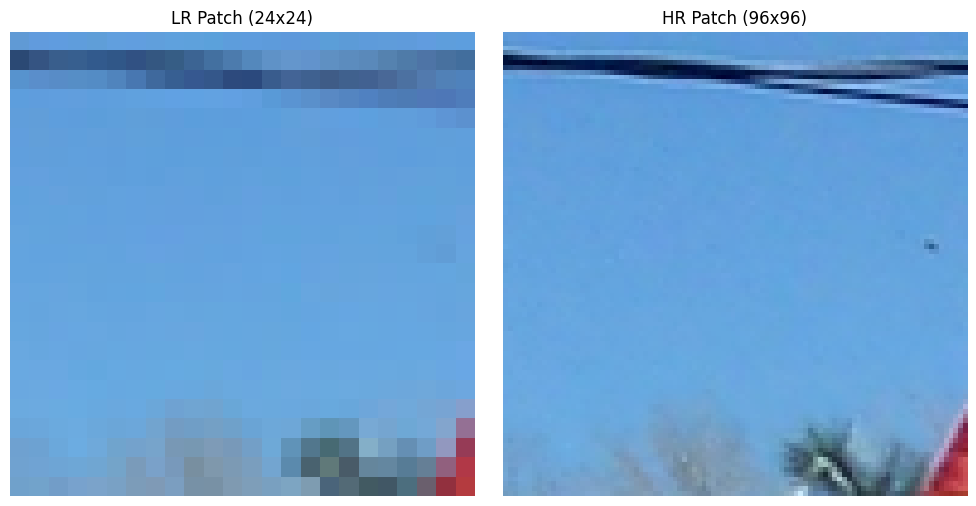


Sample from Validation Loader (Full Images):


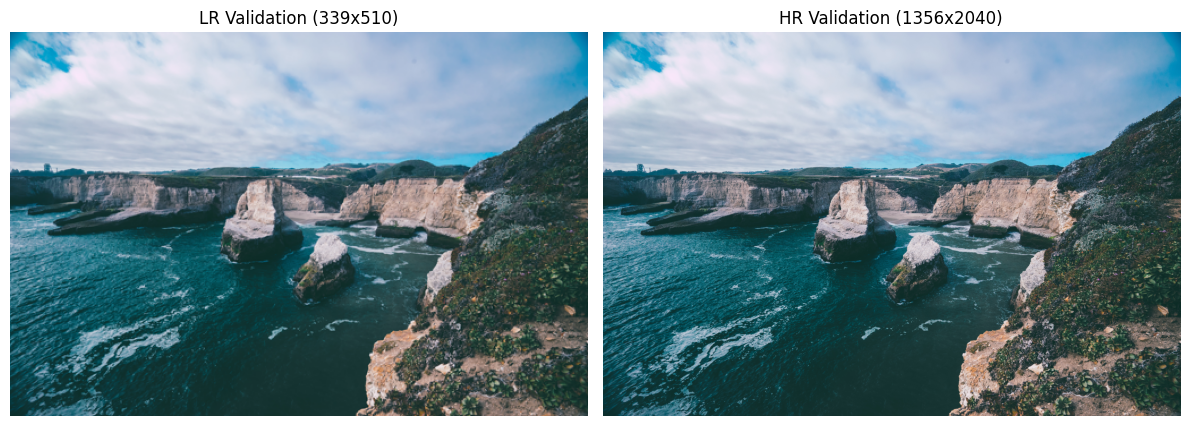

In [ ]:
# Function to display images
def show_tensor_image(tensor_img, title=""):
    img = tensor_img.squeeze().cpu().numpy().transpose(1, 2, 0)
    img = np.clip(img, 0, 1) # Ensure values are in [0, 1]
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")

# Visualize a sample from the train loader (cropped patches)
if train_loader:
    print("Sample from Training Loader (Patches):")
    try:
        lr_patch_sample, hr_patch_sample = next(iter(train_loader))
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        show_tensor_image(lr_patch_sample[0], f"LR Patch ({lr_patch_sample[0].shape[-2]}x{lr_patch_sample[0].shape[-1]})")
        plt.subplot(1, 2, 2)
        show_tensor_image(hr_patch_sample[0], f"HR Patch ({hr_patch_sample[0].shape[-2]}x{hr_patch_sample[0].shape[-1]})")
        plt.tight_layout()
        plt.show()
    except StopIteration:
        print("Could not get sample from train_loader (possibly empty dataset or split issue).")
    except Exception as e:
        print(f"Error visualizing train sample: {e}")
else:
    print("Train loader not available for visualization.")

# Visualize a sample from the validation loader (full images)
if val_loader:
    print("\nSample from Validation Loader (Full Images):")
    try:
        lr_val_sample, hr_val_sample = next(iter(val_loader))
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        show_tensor_image(lr_val_sample[0], f"LR Validation ({lr_val_sample[0].shape[-2]}x{lr_val_sample[0].shape[-1]})")
        plt.subplot(1, 2, 2)
        show_tensor_image(hr_val_sample[0], f"HR Validation ({hr_val_sample[0].shape[-2]}x{hr_val_sample[0].shape[-1]})")
        plt.tight_layout()
        plt.show()
    except StopIteration:
        print("Could not get sample from val_loader (possibly empty dataset or split issue).")
    except Exception as e:
        print(f"Error visualizing validation sample: {e}")
else:
    print("Validation loader not available for visualization.")

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(64, 64, 3, 1, 1)
        self.bn1 = nn.BatchNorm2d(64)
        self.prelu = nn.PReLU()
        self.conv2 = nn.Conv2d(64, 64, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(64)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.prelu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        return x + out

class Generator(nn.Module):
    def __init__(self, num_residual_blocks=16):
        super(Generator, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, 9, 1, 4)
        self.prelu = nn.PReLU()

        # Residual blocks
        self.residual_blocks = nn.Sequential(
            *[ResidualBlock() for _ in range(num_residual_blocks)]
        )

        self.conv2 = nn.Conv2d(64, 64, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(64)

        # Upsampling blocks
        self.upsample1 = nn.Sequential(
            nn.Conv2d(64, 256, 3, 1, 1),
            nn.PixelShuffle(2),
            nn.PReLU()
        )
        self.upsample2 = nn.Sequential(
            nn.Conv2d(64, 256, 3, 1, 1),
            nn.PixelShuffle(2),
            nn.PReLU()
        )

        self.conv3 = nn.Conv2d(64, 3, 9, 1, 4)

    def forward(self, x):
        out1 = self.prelu(self.conv1(x))
        out = self.residual_blocks(out1)
        out = self.bn2(self.conv2(out))
        out = out + out1
        out = self.upsample1(out)
        out = self.upsample2(out)
        out = self.conv3(out)
        return out


In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        def block(in_channels, out_channels, stride):
            layers = [
                nn.Conv2d(in_channels, out_channels, 3, stride, 1),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU(0.2, inplace=True)
            ]
            return layers

        self.model = nn.Sequential(
            *block(3, 64, 1),
            *block(64, 64, 2),
            *block(64, 128, 1),
            *block(128, 128, 2),
            *block(128, 256, 1),
            *block(256, 256, 2),
            *block(256, 512, 1),
            *block(512, 512, 2),
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(512, 1024, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(1024, 1, 1)
        )

    def forward(self, x):
        out = self.model(x)
        return out.view(out.size(0), -1)


In [ ]:
def train_gan_model(generator, discriminator, train_loader, num_epochs, learning_rate, device):
    # Loss functions
    pixel_loss_fn = nn.MSELoss().to(device)
    adversarial_loss_fn = nn.BCEWithLogitsLoss().to(device)

    # Optimizers
    optimizer_G = torch.optim.Adam(generator.parameters(), lr=learning_rate)
    optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=learning_rate)

    # Move models to device
    generator.to(device)
    discriminator.to(device)

    # Track average losses
    history = {
        "g_loss": [],
        "d_loss": []
    }

    for epoch in range(num_epochs):
        generator.train()
        discriminator.train()

        total_g_loss = 0
        total_d_loss = 0

        loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", leave=False)

        for lr_imgs, hr_imgs in loop:
            lr_imgs = lr_imgs.to(device)
            hr_imgs = hr_imgs.to(device)
            batch_size = lr_imgs.size(0)

            real_labels = torch.ones(batch_size, 1, device=device)
            fake_labels = torch.zeros(batch_size, 1, device=device)

            # === Train Discriminator ===
            optimizer_D.zero_grad()

            real_preds = discriminator(hr_imgs)
            d_real_loss = adversarial_loss_fn(real_preds, real_labels)

            sr_imgs = generator(lr_imgs).detach()
            fake_preds = discriminator(sr_imgs)
            d_fake_loss = adversarial_loss_fn(fake_preds, fake_labels)

            d_loss = (d_real_loss + d_fake_loss) / 2
            d_loss.backward()
            optimizer_D.step()

            # === Train Generator ===
            optimizer_G.zero_grad()

            sr_imgs = generator(lr_imgs)
            g_adv_loss = adversarial_loss_fn(discriminator(sr_imgs), real_labels)
            g_pixel_loss = pixel_loss_fn(sr_imgs, hr_imgs)
            g_loss = g_pixel_loss + 1e-3 * g_adv_loss

            g_loss.backward()
            optimizer_G.step()

            total_d_loss += d_loss.item()
            total_g_loss += g_loss.item()

            loop.set_postfix({
                "D Loss": d_loss.item(),
                "G Loss": g_loss.item()
            })

        # Compute and print epoch averages
        num_batches = len(train_loader)
        avg_d_loss = total_d_loss / num_batches
        avg_g_loss = total_g_loss / num_batches


        history["d_loss"].append(avg_d_loss)
        history["g_loss"].append(avg_g_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}] - Avg D Loss: {avg_d_loss:.4f}, Avg G Loss: {avg_g_loss:.4f}")

    return generator, history


def test_gan_model(generator, test_loader, device, vgg_extractor, vgg_loss_fn):
    generator.eval()
    vgg_extractor.eval()

    total_psnr = 0.0
    total_vgg_loss = 0.0
    num_samples = 0

    with torch.no_grad():
        for idx, (lr_imgs, hr_imgs) in enumerate(tqdm(test_loader, desc="Testing")):
            lr_imgs = lr_imgs.to(device)
            hr_imgs = hr_imgs.to(device)

            sr_imgs = generator(lr_imgs)

            # Loop through batch
            for sr_img, hr_img in zip(sr_imgs, hr_imgs):
                # --- PSNR ---
                sr_np = sr_img.cpu().clamp(0, 1).numpy().transpose(1, 2, 0)
                hr_np = hr_img.cpu().clamp(0, 1).numpy().transpose(1, 2, 0)
                psnr = calculate_psnr(hr_np, sr_np, data_range=1.0)
                total_psnr += psnr

                # --- Perceptual (VGG) Loss ---
                sr_feat = vgg_extractor(sr_img.unsqueeze(0))  # Add batch dim
                hr_feat = vgg_extractor(hr_img.unsqueeze(0))
                vgg_loss = vgg_loss_fn(sr_feat, hr_feat)
                total_vgg_loss += vgg_loss.item()

                num_samples += 1


    avg_psnr = total_psnr / num_samples
    avg_vgg = total_vgg_loss / num_samples

    print(f"\n Test Results — Avg Perceptual Loss (VGG): {avg_vgg:.6f}, Avg PSNR: {avg_psnr:.2f} dB")
    return avg_psnr, avg_vgg

In [ ]:
# Initialize and train CNN model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generator = Generator().to(device)
discriminator = Discriminator().to(device)
num_epochs = 10  # Small number for demonstration
learning_rate = 0.001

print("Training GAN model...")
start_time = time.time()
generator_model, history = train_gan_model(generator, discriminator, train_loader, num_epochs, learning_rate, device)
cnn_train_time = time.time() - start_time
print(f"Training completed in {cnn_train_time:.2f} seconds")

Training GAN model...


Epoch [1/10] - Avg D Loss: 0.6805, Avg G Loss: 0.0432


Epoch [2/10] - Avg D Loss: 0.7008, Avg G Loss: 0.0148


Epoch [3/10] - Avg D Loss: 0.6731, Avg G Loss: 0.0122


Epoch [4/10] - Avg D Loss: 0.6919, Avg G Loss: 0.0099


Epoch [5/10] - Avg D Loss: 0.6898, Avg G Loss: 0.0084


Epoch [6/10] - Avg D Loss: 0.6928, Avg G Loss: 0.0073


Epoch [7/10] - Avg D Loss: 0.6907, Avg G Loss: 0.0058


Epoch [8/10] - Avg D Loss: 0.6924, Avg G Loss: 0.0056


Epoch [9/10] - Avg D Loss: 0.6903, Avg G Loss: 0.0071


Epoch [10/10] - Avg D Loss: 0.6896, Avg G Loss: 0.0066
Training completed in 586.66 seconds


if (epoch + 1) % 1 == 0:  # save every epoch
  torch.save({
      'epoch': epoch,
      'generator_state_dict': generator.state_dict(),
      'discriminator_state_dict': discriminator.state_dict(),
      'optimizer_G_state_dict': optimizer_G.state_dict(),
      'optimizer_D_state_dict': optimizer_D.state_dict(),
  }, f"/content/drive/MyDrive/MY-SISRGAN/srgan_checkpoint_epoch{epoch+1}.pth")
  

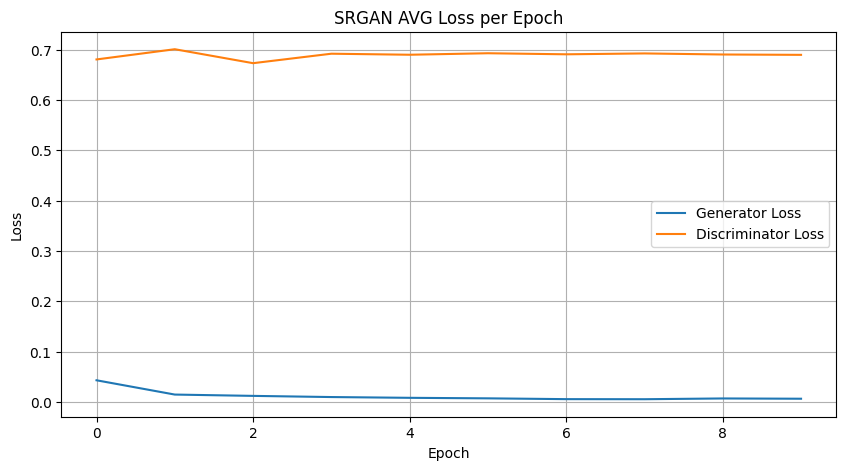

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history['g_loss'], label='Generator Loss')
plt.plot(history['d_loss'], label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('SRGAN AVG Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Test CNN model
print("\nEvaluating GAN model...")

# Load VGG19 pretrained on ImageNet
vgg = models.vgg19(pretrained=True).features
vgg = vgg.eval().to(device)
# Freeze VGG params
for param in vgg.parameters():
    param.requires_grad = False

class VGGFeatureExtractor(nn.Module):
    def __init__(self, layer_index=35):  # 35 = conv5_4
        super(VGGFeatureExtractor, self).__init__()
        self.features = nn.Sequential(*list(vgg.children())[:layer_index])

    def forward(self, x):
        return self.features(x)

vgg_loss_fn = nn.MSELoss().to(device)
vgg_extractor = VGGFeatureExtractor().to(device)

print("Evaluating GAN model...")
start_time = time.time()
avg_psnr, gg = test_gan_model(generator_model, val_loader, device, vgg_extractor=vgg_extractor, vgg_loss_fn=nn.MSELoss())
end_time = time.time()
test_time = end_time - start_time
print(f"Evaluating completed in {test_time:.2f} seconds")


# Perceptual (VGG) Loss: lower is better
# PSNR: higher is better
##########################################
# | Range    | Interpretation |
# |-------   |----------------|
# | >30 dB   | Very high fidelity (sharp and clean) |
# | 25–30 dB | Good quality SR |
# | 20–25 dB | Acceptable, but often blurry or with artifacts |
# | <20 dB   | Low quality / noisy |


# 5 epoch val avg loss : Perceptual Loss: 4.318159, PSNR: 21.58 dB ( Acceptable, but often blurry or with artifacts )
# 10 epoch val avg loss :  Perceptual Loss: 3.267976, PSNR: 23.59 dB ( Acceptable, but often blurry or with artifacts )
# 3 epoch test Results — Avg Perceptual Loss (VGG): 3.313706, Avg PSNR: 21.21 dB
# 3 epoch test Results — Avg Perceptual Loss (VGG): 3.313706, Avg PSNR: 21.21 dB

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Evaluating GAN model...


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:04<00:00, 142MB/s]


Evaluating GAN model...


Testing: 100%|██████████| 80/80 [01:54<00:00,  1.43s/it]


 Test Results — Avg Perceptual Loss (VGG): 1.692361, Avg PSNR: 24.97 dB
Evaluating completed in 114.33 seconds


In [ ]:
print("Test GAN model...")
start_time = time.time()
avg_psnr, gg = test_gan_model(generator_model, test_loader, device, vgg_extractor=vgg_extractor, vgg_loss_fn=nn.MSELoss())
end_time = time.time()
test_time = end_time - start_time
print(f"Testing completed in {test_time:.2f} seconds")


Test GAN model...


Testing: 100%|██████████| 100/100 [02:23<00:00,  1.44s/it]


 Test Results — Avg Perceptual Loss (VGG): 1.806804, Avg PSNR: 25.17 dB
Testing completed in 143.56 seconds


In [ ]:
# Visualization function

def visualize_results(model, test_loader, device, idx=0, title="Model"):
    model.to(device)
    model.eval()

    # Get a sample from the test loader
    dataiter = iter(test_loader)
    for i in range(idx + 1):
        lr_images, hr_images = next(dataiter)

    with torch.no_grad():
        lr_image = lr_images[0].to(device)
        hr_image = hr_images[0].to(device)

        # Generate super-resolution image
        sr_image = model(lr_image.unsqueeze(0)).squeeze(0)

        # Calculate PSNR
        mse = nn.MSELoss()(sr_image, hr_image).item()
        psnr = 10 * np.log10(1.0 / mse)

        # Convert tensors to numpy arrays for plotting
        lr_img = lr_image.cpu().numpy().transpose(1, 2, 0)
        hr_img = hr_image.cpu().numpy().transpose(1, 2, 0)
        sr_img = sr_image.cpu().numpy().transpose(1, 2, 0)

        # Clip values to [0, 1] range
        lr_img = np.clip(lr_img, 0, 1)
        hr_img = np.clip(hr_img, 0, 1)
        sr_img = np.clip(sr_img, 0, 1)

        # Plot images
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        axes[0].imshow(lr_img)
        axes[0].set_title('Low Resolution')
        axes[0].axis('off')

        axes[1].imshow(sr_img)
        axes[1].set_title(f'{title} Output (PSNR: {psnr:.2f}dB)')
        axes[1].axis('off')

        axes[2].imshow(hr_img)
        axes[2].set_title('High Resolution (Ground Truth)')
        axes[2].axis('off')

        plt.tight_layout()
        plt.show()

        return psnr


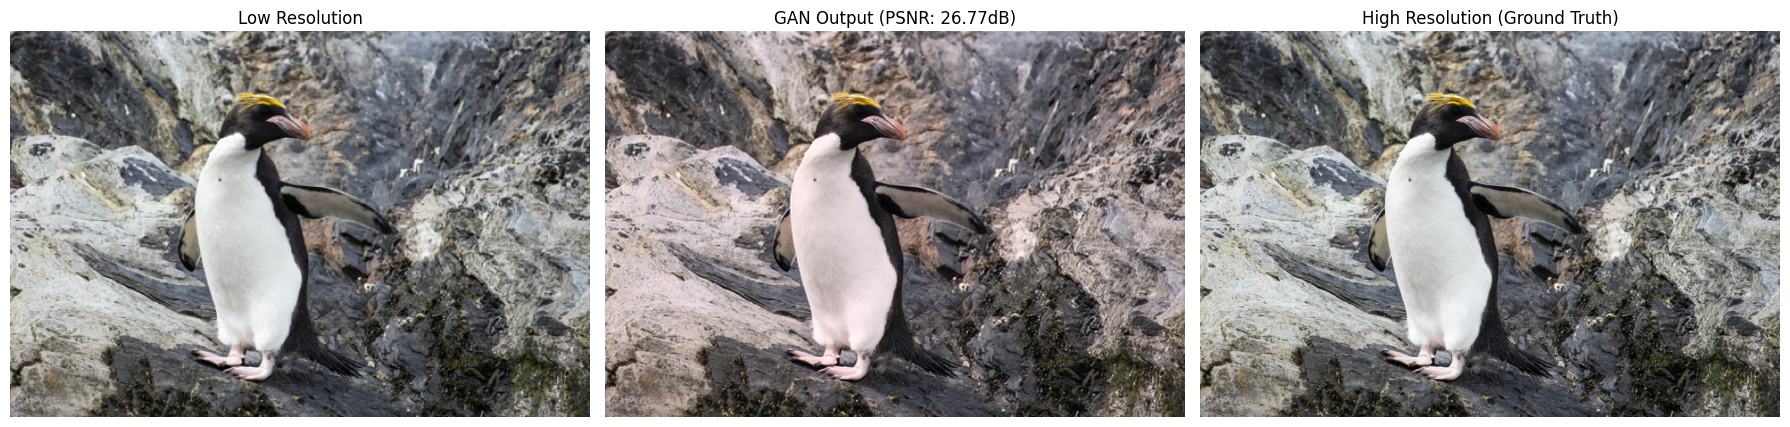

In [ ]:
# Visualize GAN results
gan_visual_psnr = visualize_results(generator_model, test_loader, device, idx=0, title="GAN")

In [ ]:
import os
if not os.path.exists("/content/drive/MyDrive"):
    from google.colab import drive
    drive.mount("/content/drive")
else:
    print("✅ Google Drive is already mounted.")


model_dir = "/content/drive/MyDrive/Final-SISR/Models"
os.makedirs(model_dir, exist_ok=True)

torch.save(generator_model.state_dict(), os.path.join(model_dir, "sisr_gan_10_2.pth"))
print("✅ Models saved successfully.")



✅ Google Drive is already mounted.
✅ Models saved successfully.


In [ ]:
import os
model_dir = "/content/drive/MyDrive/Final-SISR/Models"
os.makedirs(model_dir, exist_ok=True)

# Confirm it exists
print("Model save path:", model_dir)
!ls "$model_dir"


Model save path: /content/drive/MyDrive/Final-SISR/Models
discriminator_srgan_10.pth  generator_srgan_10.pth  sisr_gan_10.pth
discriminator_srgan1.pth    generator_srgan1.pth    test.txt
discriminator_srgan.pth     generator_srgan.pth


In [ ]:
# # assert generator_model is None, "Generator not initialized!"
# import os

# !fusermount -u /content/drive


# from google.colab import drive
# drive.mount('/content/drive')

# os.makedirs(model_dir, exist_ok=True)

# # Write a test file
# with open(os.path.join(model_dir, "test.txt"), "w") as f:
#     f.write("If you see this, writing works.")
# #

fusermount: failed to unmount /content/drive: Invalid argument


ValueError: Mountpoint must not already contain files

In [ ]:
# torch.save(optimizer_G.state_dict(), "/content/drive/MyDrive/Final-SISR/Models/optimizer_G.pth")
# torch.save(optimizer_D.state_dict(), "/content/drive/MyDrive/Final-SISR/Models/optimizer_D.pth")

NameError: name 'optimizer_G' is not defined

In [ ]:
# # Load models
# generator = Generator().to(device)
# discriminator = Discriminator().to(device)
# generator.load_state_dict(torch.load("/content/drive/MyDrive/MY-SISRGAN/Models/generator_srgan.pth"))
# discriminator.load_state_dict(torch.load("/content/drive/MyDrive/MY-SISRGAN/discriminator_srgan.pth"))
# generator.eval()  # set to evaluation mode
# discriminator.eval()


In [ ]:
# optimizer_G.load_state_dict(torch.load("/content/drive/MyDrive/MY-SISRGAN/optimizer_G.pth"))
# optimizer_D.load_state_dict(torch.load("/content/drive/MyDrive/MY-SISRGAN/optimizer_D.pth"))


In [ ]:
# if (epoch + 1) % 1 == 0:  # save every epoch
#     torch.save({
#         'epoch': epoch,
#         'generator_state_dict': generator.state_dict(),
#         'discriminator_state_dict': discriminator.state_dict(),
#         'optimizer_G_state_dict': optimizer_G.state_dict(),
#         'optimizer_D_state_dict': optimizer_D.state_dict(),
#     }, f"/content/drive/MyDrive/srgan_checkpoint_epoch{epoch+1}.pth")


# # checkpoint = torch.load("/content/drive/MyDrivesrgan_checkpoint_epoch3.pth")
# # generator.load_state_dict(checkpoint['generator_state_dict'])
# # discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
# # optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
# # optimizer_D.load_state_dict(checkpoint['optimizer_D_state_dict'])
# # start_epoch = checkpoint['epoch'] + 1
